In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':2}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
figDir = '/Users/aqib/Desktop/BCCL/char-syn-gene-nets/MSB_submission/figures/'

from scipy.signal import savgol_filter as savgol
import seaborn as sns
import scanpy as sc

from read_PR_data import PR_2_dicts # PR stands for plate reader 

In [3]:
def read_pr_data_and_metadata(datafile, metadatafile, metadatasubfile, nRows=8, nCols=12, sampling_rate=5):
    '''
    Inputs
    ------
    
        datafile : str
            The path to the file containing the plate reader data (in tab delimited format)
    
        metadatafile : str, 
            The path to the metadata file (as comma separated values)
    
        metadatasubfile : str
            The sheet name in the metadatafile
            
        nRows : int
            Number of rows measured in the plate reader experiment
        
        nCols : int
            Number of columns measured in the plate reader experiment
            
        sampling_rate : float or int
            Interval between data samples from the plate reader experiment
        
    Returns 
    -------
    
        adata : Anndata object
            adata.X contains the optical density as a numpy array 
            adata.obsm['fl'] contains the fluorescence as a numpy array 
            adata.obsm['fln'] contains the OD normalized fluorescence as a numpy array 
            adata.obs contains the metadata in a pandas dataframe
            adata.uns['t'] contains the time span in hours
    '''
    
    data, nReads = PR_2_dicts(datafile,nRows,nCols) # get the OD and fluorescence measurements in a dictionary called data
    od, fl = data # unpack
    tspan = np.linspace(0,nReads*sampling_rate,nReads)/60 # represent time in hours
    
    # get metadata 
    xls = pd.ExcelFile(metadatafile)
    obs = pd.read_excel(xls,metadatasubfile,index_col=0)
    
    # remove keys from data dictionaries if not present in metadata
    keys_to_remove = list( set(list(od.keys())) - set(obs.index.tolist()) )
    for key in keys_to_remove: 
        del od[key]
        del fl[key]

    # OD normalize the fluorescence measurements
    fln = {}
    for key in fl:
        fln[key] = fl[key]/od[key] 
    
    # reorder obs to have same row order as od
    indices = pd.DataFrame(od).T.index.tolist()
    obs = obs.reindex(indices)
    
    # put the data in anndata format for easy parsing of both data modalities and metadata
    adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
    adata.obsm['fln'] = pd.DataFrame(fln).T # normalized fluorescence
    adata.obsm['fl'] = pd.DataFrame(fl).T # fluorescence
    adata.uns['t'] = tspan # time span
    
    return adata

# Antibiotic screens

### A. baylyi ADP1 WT, ACIAD_RS12300, and ACIAD_RS09335 -- lag phase, 8 µg/mL ampicillin, 100 µM SD8 10.12

In [4]:
dataFile = 'adp1_antibiotic_10.12.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.12'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/var/folders/s9/jslg0t1x19s8p_kd2svbjp8h0000gn/T/ipykernel_22123/1631208092.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


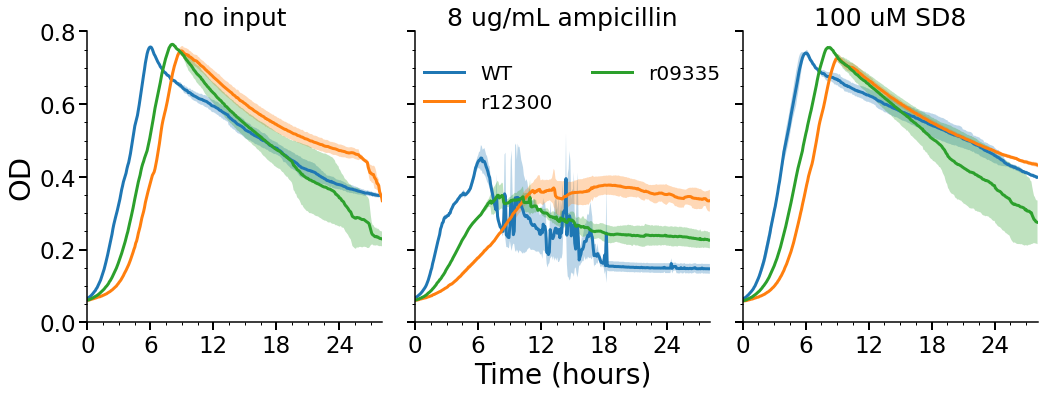

In [76]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (15, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'SD8':
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### A. baylyi ADP1 WT, ACIAD_RS12300, and ACIAD_RS14095 -- log phase, 8 µg/mL ampicillin, 16 µg/mL ampicillin 10.16

In [9]:
dataFile = 'adp1_antibiotic_10.16.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.16'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


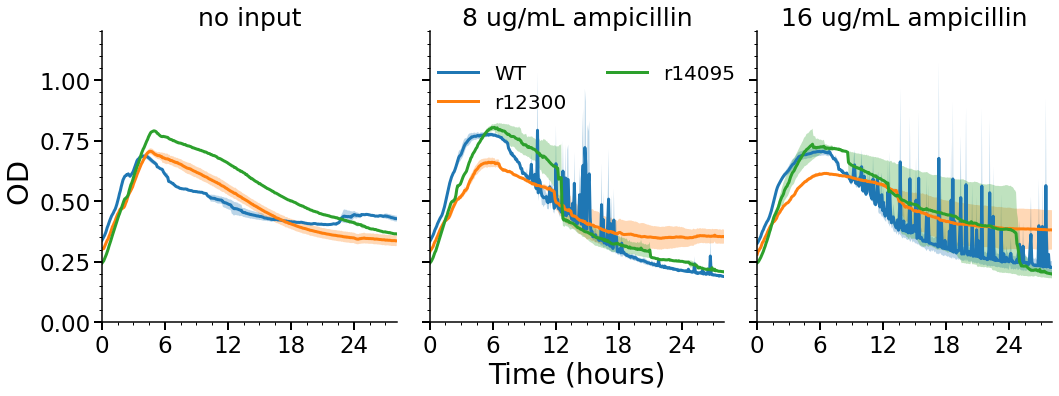

In [10]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (15, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X[0:2],axis=0)
    std = np.std(bdata.X[0:2],axis=0)
    if bdata.obs.compound[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 8:
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 16:
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD ',fontsize=29)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/adp1-adaptation/results/OD_10.16.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### ADP1 WT and ADP1 w/ pBWB162 -- lag phase, 8 ug/mL ampicillin, vary IPTG 10.19

In [5]:
dataFile = 'adp1_antibiotic_10.19.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.18'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/var/folders/s9/jslg0t1x19s8p_kd2svbjp8h0000gn/T/ipykernel_22123/1631208092.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


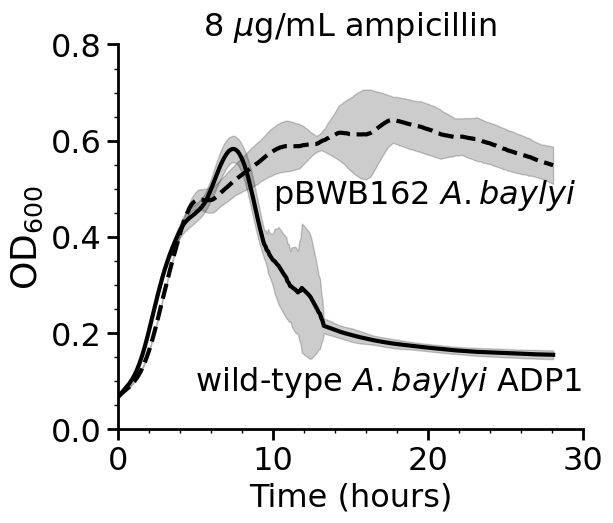

In [6]:
savefig = False

plt.figure(figsize=(6,5))
bdata = adata[adata.obs.condition.isin([2,3])].copy()
labels = ['wild-type $\it{A. baylyi}$ ADP1', 'pBWB162 $\it{A. baylyi}$']
linestyles = ['-','--']
for ii, strain in enumerate(bdata.obs.strain.unique()):
    cdata = bdata[bdata.obs.strain.isin([strain])].copy()
    mean = savgol(np.mean(cdata.X,axis=0),17,1)
#     mean = np.mean(cdata.obsm['fln'],axis=0)
    std = savgol(np.std(cdata.X,axis=0),17,1)
#     std = np.std(cdata.obsm['fln'],axis=0)
    plt.plot(adata.uns['t'],mean,linestyles[ii],c='k')
    plt.fill_between(adata.uns['t'],mean-2*std,mean+2*std,alpha=0.2,color='k')
# plt.legend(frameon=False,fontsize=21,loc=(0.25,0.14))
plt.title(r'8 $\mu$g/mL ampicillin',fontsize=23)
plt.text(10,0.47,labels[1])
plt.text(5,0.08,labels[0])
plt.xlabel('Time (hours)',fontsize=23); plt.ylabel(r'OD$_{600}$',fontsize=26)
plt.ylim(-0.0,0.8)
if savefig: 
    plt.savefig(figDir+'fig4/adp1_gcs_amp.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

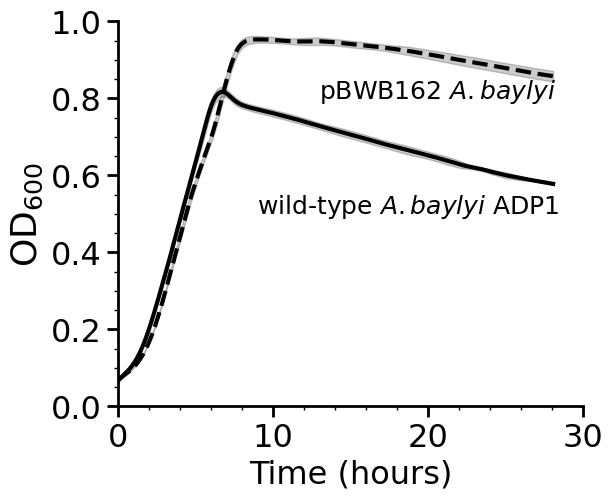

In [30]:
plt.figure(figsize=(6,5))
bdata = adata[adata.obs.condition.isin([0,1])].copy()
labels = ['wild-type $\it{A. baylyi}$ ADP1', 'pBWB162 $\it{A. baylyi}$']
linestyles = ['-','--']
for ii, strain in enumerate(bdata.obs.strain.unique()):
    cdata = bdata[bdata.obs.strain.isin([strain])].copy()
    mean = savgol(np.mean(cdata.X,axis=0),17,1)
    std = savgol(np.std(cdata.X,axis=0),17,1)
    plt.plot(adata.uns['t'],mean,linestyles[ii],c='k')
    plt.fill_between(adata.uns['t'],mean-2*std,mean+2*std,alpha=0.2,color='k')
plt.text(13,0.8,labels[1],fontsize=18)
plt.text(9,0.5,labels[0],fontsize=18)
plt.xlabel('Time (hours)',fontsize=23); plt.ylabel(r'OD$_{600}$',fontsize=26)
# plt.ylim(-0.0,0.8)
plt.show()

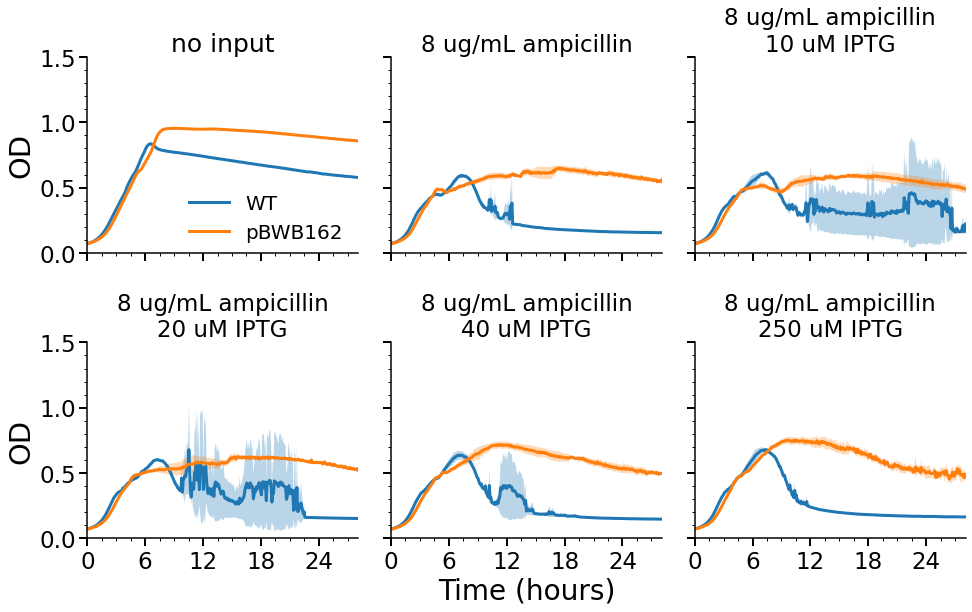

In [13]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(2,3,figsize = (14, 9),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 10:
        ax[2].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 20:
        ax[3].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[3].plot(adata.uns['t'],mean)
        ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 40:
        ax[4].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[4].plot(adata.uns['t'],mean)
        ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 250:
        ax[5].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[5].plot(adata.uns['t'],mean)
        ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[4].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[3].set_ylabel('OD',fontsize=29);
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.375,0.7),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

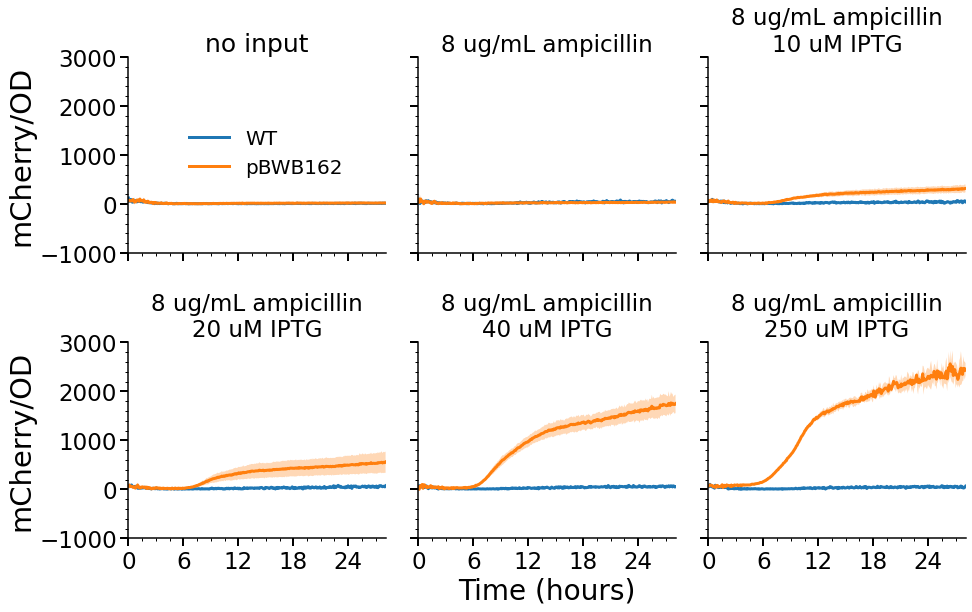

In [14]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(2,3,figsize = (14, 9),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 10:
        ax[2].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 20:
        ax[3].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[3].plot(adata.uns['t'],mean)
        ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 40:
        ax[4].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[4].plot(adata.uns['t'],mean)
        ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.concentration_1[0] == 250:
        ax[5].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[5].plot(adata.uns['t'],mean)
        ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[4].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('mCherry/OD',fontsize=29); ax[3].set_ylabel('mCherry/OD',fontsize=29);
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.375,0.8),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

In [15]:
# scatter plot of IPTG vs. deltaOD

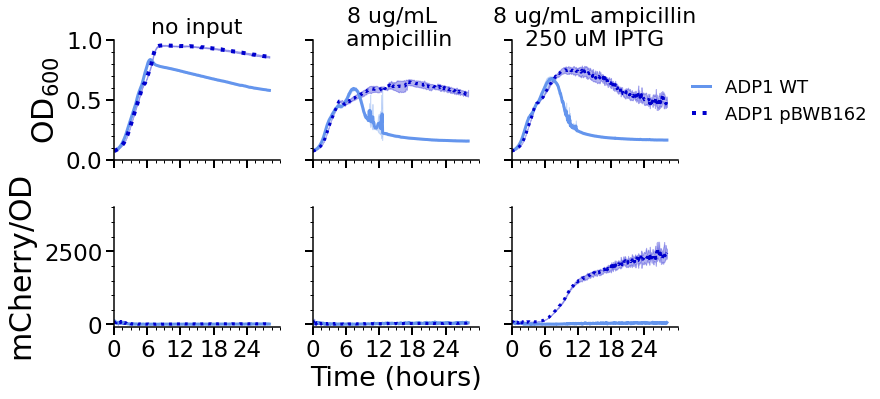

In [142]:
# amp resistance figure for paper 
savefig = False

fig, ax = plt.subplots(2,3,figsize = (10, 6),sharex=True,sharey='row')
ax = ax.reshape(-1)
alpha = 0.3
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
colors = ['cornflowerblue','mediumblue']
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        if bdata.obs.strain[0] == 'WT':
            ax[0].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[0].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} \n {bdata.obs.compound_2[0]}',fontsize=22,y=0.9)
        if bdata.obs.strain[0] == 'WT':
            ax[1].plot(adata.uns['t'],mean,color=colors[0])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[1].plot(adata.uns['t'],mean,':',color=colors[1])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])        
    elif bdata.obs.concentration_1[0] == 250:
        ax[2].set_title(f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}' + '\n' 
                        f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=22,y=0.9)
        if bdata.obs.strain[0] == 'WT':
            ax[2].plot(adata.uns['t'],mean,c=colors[0])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[2].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
            
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        if bdata.obs.strain[0] == 'WT':
            ax[3].plot(adata.uns['t'],mean,c=colors[0])
            ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[3].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[3].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'ampicillin':
        if bdata.obs.strain[0] == 'WT':
            ax[4].plot(adata.uns['t'],mean,c=colors[0])
            ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[4].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[4].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])       
    elif bdata.obs.concentration_1[0] == 250:
        if bdata.obs.strain[0] == 'WT':
            ax[5].plot(adata.uns['t'],mean,c=colors[0])
            ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else: 
            ax[5].plot(adata.uns['t'],mean,':',c=colors[1])
            ax[5].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
            
ax[0].set_title('no input',fontsize=22,y=1)
ax[0].set_ylabel(r'OD$_{600}$',fontsize=30); 
ax[3].set_ylabel(r'mCherry$/$OD',fontsize=30); 
ax[4].set_xlabel('Time (hours)',fontsize=27)
# fig.text(0.46,-0.01,'Time (hours)',fontsize=25)  
fig.legend(['ADP1 WT','ADP1 pBWB162'],fontsize=18,bbox_to_anchor=(1.25,0.82),ncol=1,handlelength=1,frameon=False)
ax[4].set_ylim(-100,)
ax[0].set_xlim(0,30)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig4/adp1_ampicillin.pdf',transparent=True,bbox_inches='tight',dpi=300);
plt.show()

### MGZ1 WT and MGZ1 w dCasRx plasmid (from Alec), 20 uM IPTG, 5 ug/mL amp, 30C 11.9

In [31]:
dataFile = 'mgz1_antibiotic_h1_11.9.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_antibiotic_11.9'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/var/folders/s9/jslg0t1x19s8p_kd2svbjp8h0000gn/T/ipykernel_22123/1631208092.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


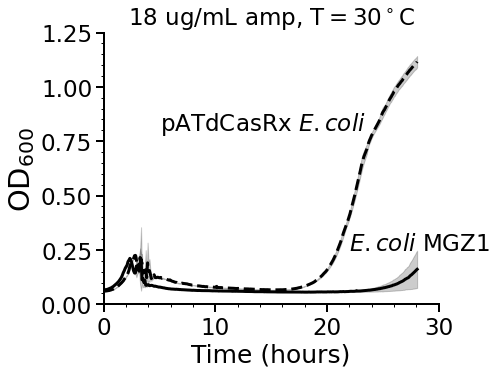

In [191]:
savefig = False

labels = ['$\it{E. coli}$ MGZ1', 'pATdCasRx $\it{E. coli}$']

plt.figure(figsize=(6,5))
plt.title('18 ug/mL amp, T$=30^\circ\mathrm{C}$',fontsize=23)
mean = adata[['D7','D8','D9']].X.toarray().mean(axis=0)
std = adata[['D7','D8','D9']].X.toarray().std(axis=0)
plt.plot(adata.uns['t'],mean,'--k') 
plt.fill_between(adata.uns['t'],mean-std,mean+std,color='k',alpha=0.2) 
mean = adata[['D4','D5','D6']].X.toarray().mean(axis=0)
std = adata[['D4','D5','D6']].X.toarray().std(axis=0)
plt.plot(adata.uns['t'],mean,'-k') 
plt.fill_between(adata.uns['t'],mean-std,mean+std,color='k',alpha=0.2) 
# plt.ylim(0,1.7)
# plt.xlim(0,30)
plt.text(5,0.8,labels[1])
plt.text(22,0.25,labels[0])
plt.xlabel('Time (hours)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
if savefig: 
    plt.savefig(figDir+'supplementalFigs/mgz1_t30_amp18.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()



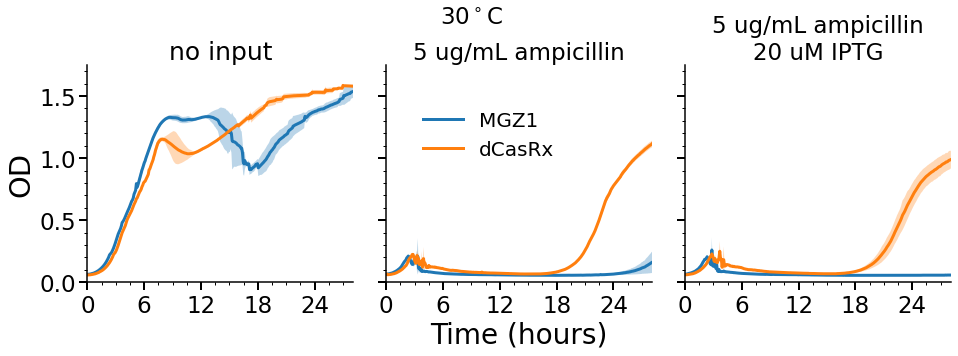

In [20]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (14, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'none':
        ax[1].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'IPTG':
        ax[2].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}' + '\n' 
                        f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
plt.suptitle(r'30$^\circ$C',fontsize=23,y=0.85)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.6,0.65),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/mgz1_t30_amp18.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### MGZ1 WT and MGZ1 w dCasRx plasmid (from Alec), 20 uM IPTG, 5 ug/mL amp, 37C 11.9

In [170]:
dataFile = 'mgz1_antibiotic_neo2_11.9.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_antibiotic_11.9'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


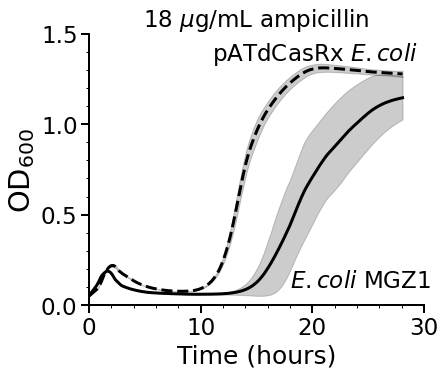

In [171]:
savefig = False

plt.figure(figsize=(6,5))
plt.title(r'18 $\mu$g/mL ampicillin',fontsize=23)
bdata = adata[adata.obs.condition.isin([2,3])].copy()
labels = ['$\it{E. coli}$ MGZ1', 'pATdCasRx $\it{E. coli}$']
linestyles = ['-','--']
for ii, strain in enumerate(bdata.obs.strain.unique()):
    cdata = bdata[bdata.obs.strain.isin([strain])].copy()
    mean = savgol(np.mean(cdata.X,axis=0),15,1)
#     mean = np.mean(cdata.obsm['fln'],axis=0)
    std = savgol(np.std(cdata.X,axis=0),15,1)
#     std = np.std(cdata.obsm['fln'],axis=0)
    plt.plot(adata.uns['t'],mean,linestyles[ii],c='k')
    plt.fill_between(adata.uns['t'],mean-std,mean+std,alpha=0.2,color='k')
# plt.legend(frameon=False,fontsize=21,loc=(0.25,0.14))
plt.text(11,1.35,labels[1])
plt.text(18,0.1,labels[0])
plt.xlabel('Time (hours)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
plt.ylim(-0.0,1.5)
if savefig: 
    plt.savefig(figDir+'fig4/mgz1_gcs_amp.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

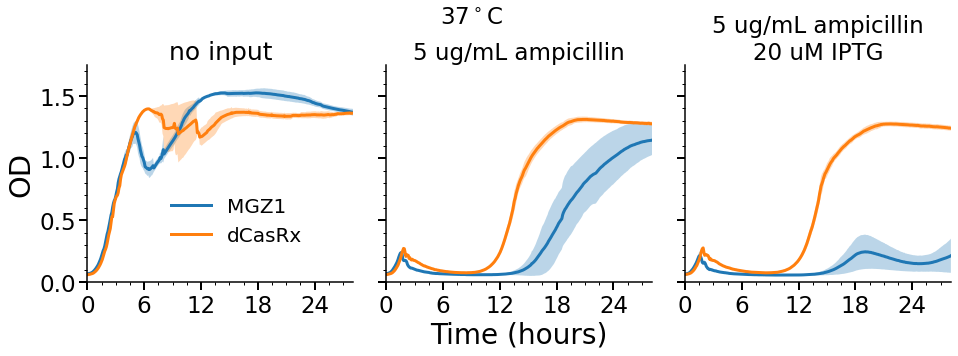

In [22]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (14, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'none':
        ax[1].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}',fontsize=23)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'IPTG':
        ax[2].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}' + '\n' 
                        f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=23)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
plt.suptitle(r'37$^\circ$C',fontsize=23,y=0.85)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(.35,0.45),ncol=1)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

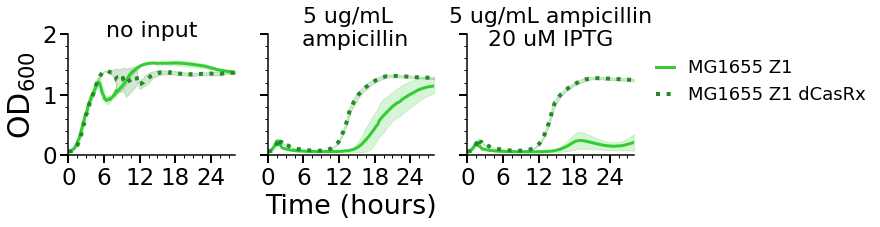

In [165]:
# amp resistance figure for paper 
savefig = False

fig, ax = plt.subplots(1,3,figsize = (9.7, 3.5),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.2
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
colors = ['limegreen','forestgreen']
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound_1[0] == 'none' and bdata.obs.compound_2[0] == 'none':
        if bdata.obs.strain[0] == 'MGZ1':
            ax[0].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[0].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'none':
        ax[1].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} \n {bdata.obs.compound_1[0]}',fontsize=22,y=0.85)
        if bdata.obs.strain[0] == 'MGZ1':
            ax[1].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[1].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
    elif bdata.obs.compound_1[0] == 'ampicillin' and bdata.obs.compound_2[0] == 'IPTG':
        ax[2].set_title(f'{bdata.obs.concentration_1[0]} {bdata.obs.concentration_unit_1[0]} {bdata.obs.compound_1[0]}' + '\n' 
                        f'{bdata.obs.concentration_2[0]} {bdata.obs.concentration_unit_2[0]} {bdata.obs.compound_2[0]}',fontsize=22,y=0.85)
        if bdata.obs.strain[0] == 'MGZ1':
            ax[2].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        else:
            ax[2].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
ax[0].set_title('no input',fontsize=22,y=0.93)
ax[0].set_ylabel(r'OD$_{600}$',fontsize=30)
ax[1].set_xlabel('Time (hours)',fontsize=27)
fig.legend(['MG1655 Z1','MG1655 Z1 dCasRx'],bbox_to_anchor=(1.32,0.8),fontsize=18,ncol=1,handlelength=1,frameon=False)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig4/mgz1_ampicillin.pdf',transparent=True,bbox_inches='tight',dpi=300);
plt.show()

### B. subtilis 168 ampicillin test with mCherry 1x and 4x strains.

Problem is that I didn't culture the strains with antibiotic as they don't grow in erythromycin but should be resistant. So probably don't trust this experiment.

In [117]:
dataFile = '168_antibiotic_11.19.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = '168_antibiotic_11.19' 
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


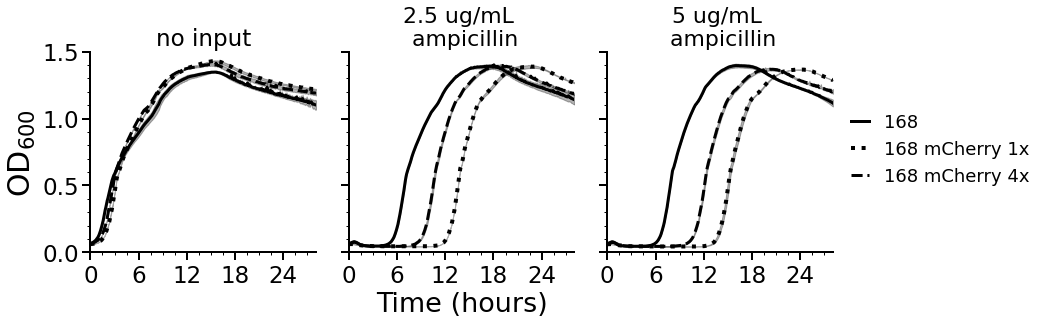

In [128]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize=(15, 5),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
colors = ['k','k','k']
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X[0:2],axis=0)
    std = np.std(bdata.X[0:2],axis=0)
    if bdata.obs.compound[0] == 'none':
        if bdata.obs.strain[0] == 168:
            ax[0].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        elif bdata.obs.strain[0] == '1x':
            ax[0].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
        else: 
            ax[0].plot(adata.uns['t'],mean,'--',lw=3,c=colors[2])            
            ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[2])            
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 2.5:
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} \n {bdata.obs.compound[0]}',fontsize=22,)
        if bdata.obs.strain[0] == 168:
            ax[1].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        elif bdata.obs.strain[0] == '1x':
            ax[1].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
        else: 
            ax[1].plot(adata.uns['t'],mean,'--',lw=3,c=colors[2])            
            ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[2])            
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 5:
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} \n {bdata.obs.compound[0]}',fontsize=22,)
        if bdata.obs.strain[0] == 168:
            ax[2].plot(adata.uns['t'],mean,'-',c=colors[0])
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[0])
        elif bdata.obs.strain[0] == '1x':
            ax[2].plot(adata.uns['t'],mean,':',lw=4,c=colors[1])            
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[1])
        else: 
            ax[2].plot(adata.uns['t'],mean,'--',lw=3,c=colors[2])            
            ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=colors[2])            
ax[0].set_title('no input',fontsize=23)
ax[1].set_xlabel('Time (hours)',fontsize=27)
ax[0].set_ylabel(r'OD$_{600}$',fontsize=30); 
# fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.legend(['168','168 mCherry 1x', '168 mCherry 4x'],loc=(1.05,0.3),fontsize=18,ncol=1,handlelength=1,frameon=False)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/168_amp_gcs.pdf',transparent=True,bbox_inches='tight',dpi=300);
plt.show()

### MG1655 Delta LacI with mepM overexpression plasmid - mepM titration and mCherry measurements (12.9.22) colony checks

In [60]:
dataFile = 'mg1655DeltaLacI_mepMoverexpress_amp_12.9.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgDeltaLacI_mepMover_12.9.22'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [61]:
plot_colors = ['gold','hotpink','darkviolet','mediumblue']
linestyles = ['-','--','-.',':']

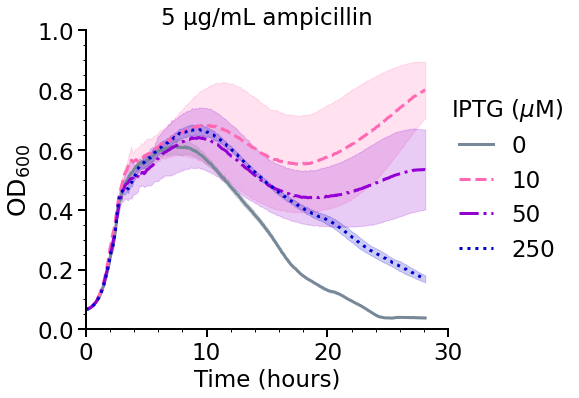

In [98]:
savefig = False

condition = [23, 14, 17, 20] # C3 | vary IPTG 0, 10, 50, 250 | 8 µg/mL ampicillin
plt.figure(figsize=(6.5,5.5))
alpha = 0.2
plt.title(r'5 µg/mL ampicillin',fontsize=23)
for ii, cond in enumerate(condition): 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    plt.plot(adata.uns['t'],mean,label=f'{iptg_conc}',color=plot_colors[ii],linestyle=linestyles[ii])
    plt.fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=plot_colors[ii])
plt.ylim(0,)
plt.xlabel('Time (hours)',fontsize=23)
plt.ylabel(r'OD$_{600}$',fontsize=25);
plt.legend(frameon=False,fontsize=23,bbox_to_anchor=(0.95,0.85),ncol=1,title=r'IPTG ($\mu$M)',handlelength=1.5)
if savefig:
    plt.savefig(figDir+'fig5/mgdeltalacI_gcs_amp.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

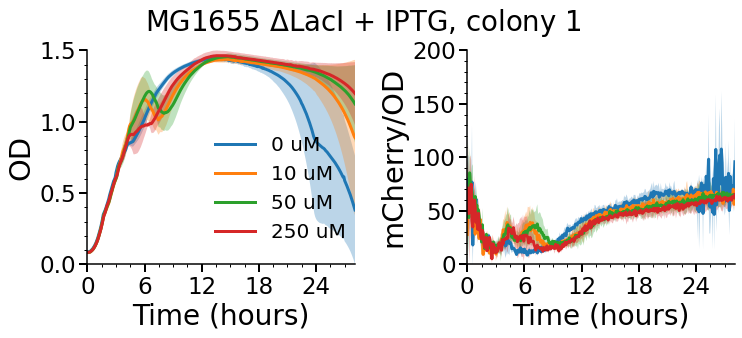

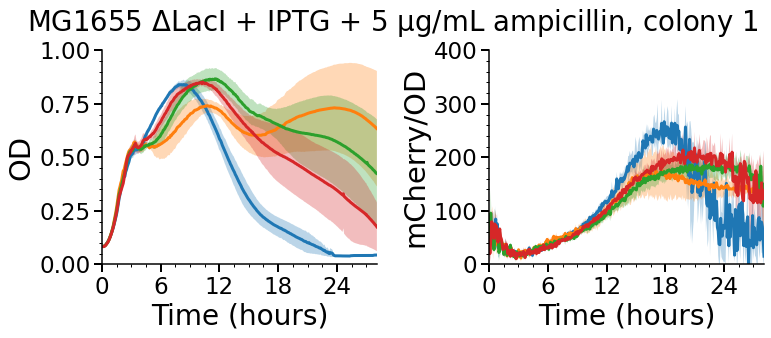

In [72]:
condition = [0, 3, 6, 9] # C1 | vary IPTG 0, 10, 50, 250 | no ampicillin
fig, ax = plt.subplots(1,2,figsize=(11,5.5))
alpha = 0.3
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
plt.suptitle(r'MG1655 $\Delta$LacI + IPTG, colony 1',y=0.88)
for cond in condition: 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    ax[0].plot(adata.uns['t'],mean,label=f'{iptg_conc} {iptg_unit}')
    ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    ax[1].plot(adata.uns['t'],mean)
    ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[1].set_ylim(0,)
ax[0].set_xlabel('Time (hours)',fontsize=28); ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[1].set_ylabel('mCherry/OD',fontsize=29); 
fig.legend(frameon=False,fontsize=20,bbox_to_anchor=(.5,0.6),ncol=1)
plt.tight_layout()
plt.show()

condition = [21, 12, 15, 18] # C1 | vary IPTG 0, 10, 50, 250 | 8 µg/mL ampicillin
fig, ax = plt.subplots(1,2,figsize=(11,5.5))
alpha = 0.3
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
plt.suptitle(r'MG1655 $\Delta$LacI + IPTG + 5 µg/mL ampicillin, colony 1',y=0.88)
for cond in condition: 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    ax[0].plot(adata.uns['t'],mean,label=f'{iptg_conc} {iptg_unit}')
    ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    ax[1].plot(adata.uns['t'],mean)
    ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[1].set_ylim(0,)
ax[0].set_xlabel('Time (hours)',fontsize=28); ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[1].set_ylabel('mCherry/OD',fontsize=29); 
# fig.legend(frameon=False,fontsize=20,bbox_to_anchor=(.5,0.6),ncol=1)
plt.tight_layout()
plt.show()

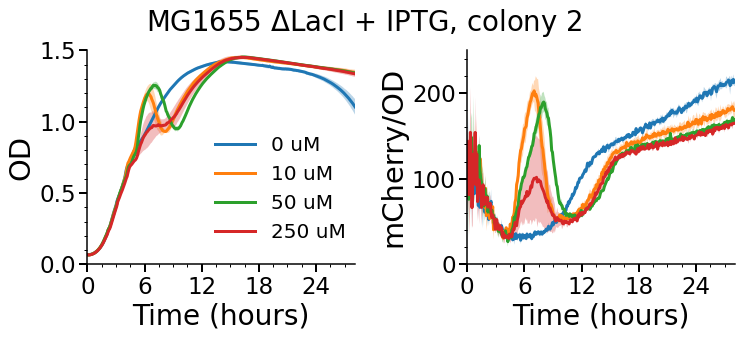

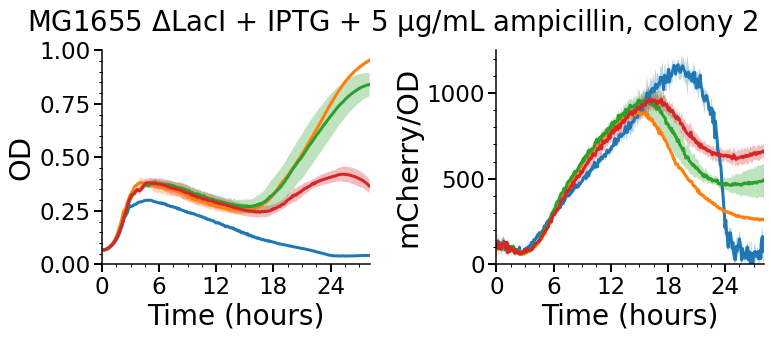

In [73]:
condition = [1, 4, 7, 10] # C2 | vary IPTG 0, 10, 50, 250 | no ampicillin
fig, ax = plt.subplots(1,2,figsize=(11,5.5))
alpha = 0.3
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
plt.suptitle(r'MG1655 $\Delta$LacI + IPTG, colony 2',y=0.88)
for cond in condition: 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    ax[0].plot(adata.uns['t'],mean,label=f'{iptg_conc} {iptg_unit}')
    ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    ax[1].plot(adata.uns['t'],mean)
    ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[1].set_ylim(0,)
ax[0].set_xlabel('Time (hours)',fontsize=28); ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[1].set_ylabel('mCherry/OD',fontsize=29); 
fig.legend(frameon=False,fontsize=20,bbox_to_anchor=(.5,0.6),ncol=1)
plt.tight_layout()
plt.show()

condition = [22, 13, 16, 19] # C2 | vary IPTG 0, 10, 50, 250 | 8 µg/mL ampicillin
fig, ax = plt.subplots(1,2,figsize=(11,5.5))
alpha = 0.3
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
plt.suptitle(r'MG1655 $\Delta$LacI + IPTG + 5 µg/mL ampicillin, colony 2',y=0.88)
for cond in condition: 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    ax[0].plot(adata.uns['t'],mean,label=f'{iptg_conc} {iptg_unit}')
    ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    ax[1].plot(adata.uns['t'],mean)
    ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[1].set_ylim(0,)
ax[0].set_xlabel('Time (hours)',fontsize=28); ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[1].set_ylabel('mCherry/OD',fontsize=29); 
# fig.legend(frameon=False,fontsize=20,bbox_to_anchor=(.5,0.6),ncol=1)
plt.tight_layout()
plt.show()

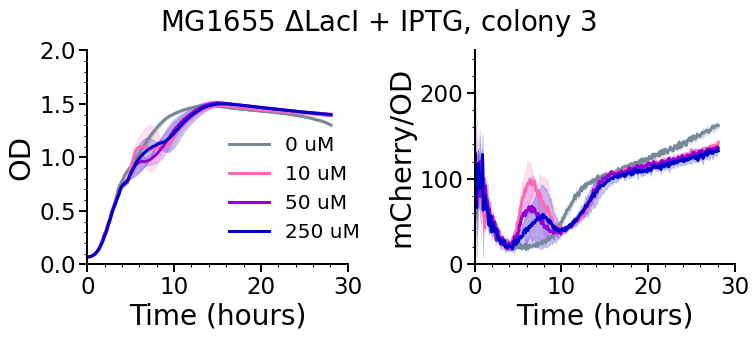

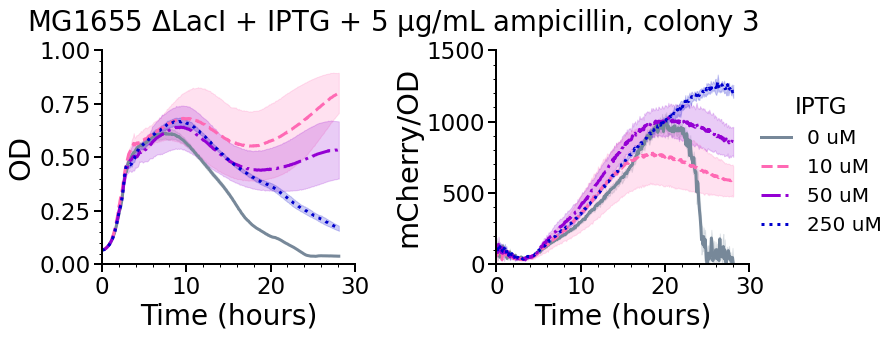

In [62]:
plot_colors = ['lightslategray','hotpink','darkviolet','mediumblue']
linestyles = ['-','--','-.',':']

condition = [2, 5, 8, 11] # C3 | vary IPTG 0, 10, 50, 250 | no ampicillin
fig, ax = plt.subplots(1,2,figsize=(11,5.5))
alpha = 0.2
# plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
plt.suptitle(r'MG1655 $\Delta$LacI + IPTG, colony 3',y=0.88)
for ii, cond in enumerate(condition): 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    ax[0].plot(adata.uns['t'],mean,label=f'{iptg_conc} {iptg_unit}',color=plot_colors[ii])
    ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=plot_colors[ii])
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    ax[1].plot(adata.uns['t'],mean,color=plot_colors[ii])
    ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=plot_colors[ii])
ax[1].set_ylim(0,)
ax[0].set_xlabel('Time (hours)',fontsize=28); ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[1].set_ylabel('mCherry/OD',fontsize=29); 
fig.legend(frameon=False,fontsize=20,bbox_to_anchor=(.5,0.6),ncol=1)
plt.tight_layout()
plt.show()

condition = [23, 14, 17, 20] # C3 | vary IPTG 0, 10, 50, 250 | 8 µg/mL ampicillin
fig, ax = plt.subplots(1,2,figsize=(11,5.5))
alpha = 0.2
# plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
plt.suptitle(r'MG1655 $\Delta$LacI + IPTG + 5 µg/mL ampicillin, colony 3',y=0.88)
for ii, cond in enumerate(condition): 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    ax[0].plot(adata.uns['t'],mean,label=f'{iptg_conc} {iptg_unit}',color=plot_colors[ii],linestyle=linestyles[ii])
    ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=plot_colors[ii])
    mean = np.mean(bdata.obsm['fln'],axis=0)
    std = np.std(bdata.obsm['fln'],axis=0)
    ax[1].plot(adata.uns['t'],mean,color=plot_colors[ii],linestyle=linestyles[ii])
    ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha,color=plot_colors[ii])
ax[1].set_ylim(0,)
ax[0].set_xlabel('Time (hours)',fontsize=28); ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29); ax[1].set_ylabel('mCherry/OD',fontsize=29); 
fig.legend(frameon=False,fontsize=20,bbox_to_anchor=(1.14,0.7),ncol=1,title='IPTG',handlelength=1.5)
plt.tight_layout()
plt.show()

### MG1655 Delta LacI with mepM overexpression plasmid - mepM titration and mCherry measurements (12.13.22) - 10 IPTG concentrations (colony 3) 

In [581]:
dataFile = 'mg1655DeltaLacI_mepMoverexpress_12.13.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgDeltaLacI_mepMover_12.13.22'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


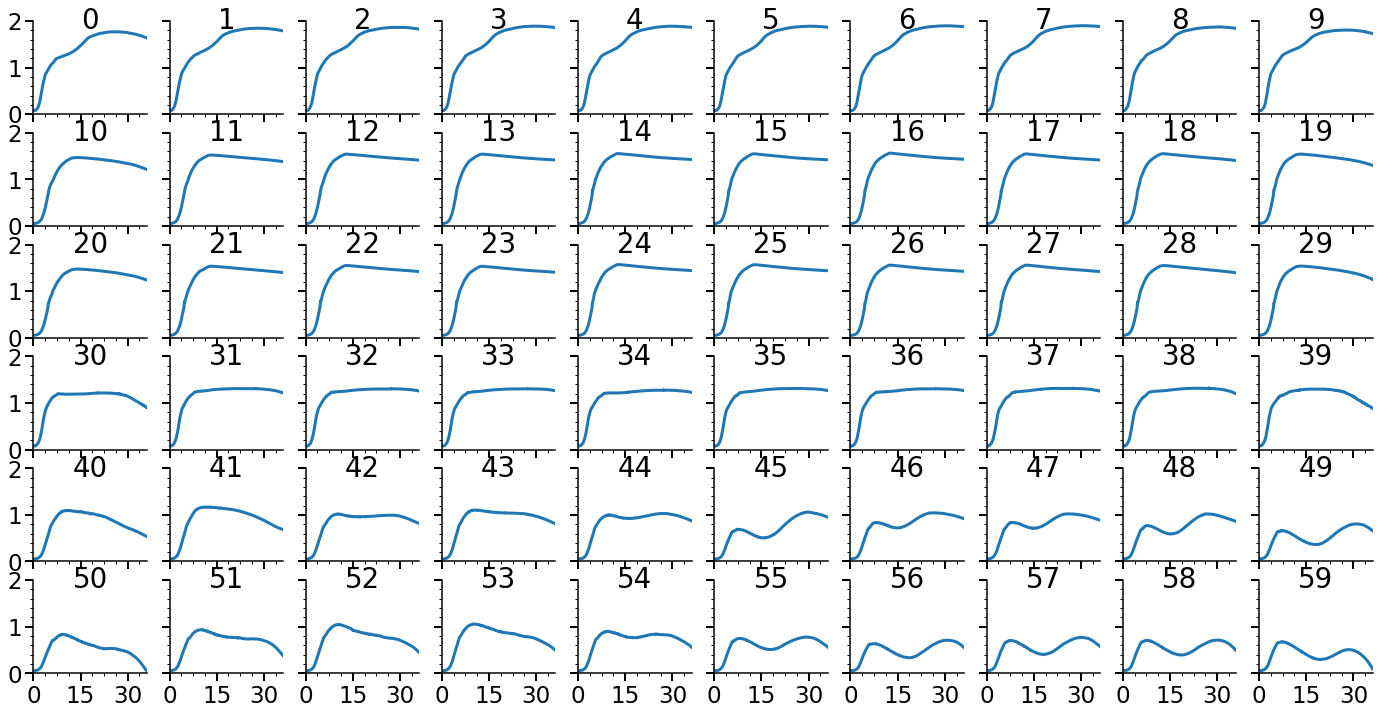

In [588]:
fig, axs = plt.subplots(6,10,figsize=(24,12),sharex=True,sharey=True)
axs = axs.reshape(-1)
plt.setp(axs, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii, ax in enumerate(axs): 
    ax.set_title(ii,y=0.85)
    ax.plot(adata.uns['t'], adata.X[ii])
#     ax.plot(adata.uns['t'], adata.obsm['fln'].iloc[ii])
#     ax.plot(adata.uns['t'], adata.obsm['fl'].iloc[ii])
# plt.tight_layout()
plt.show()

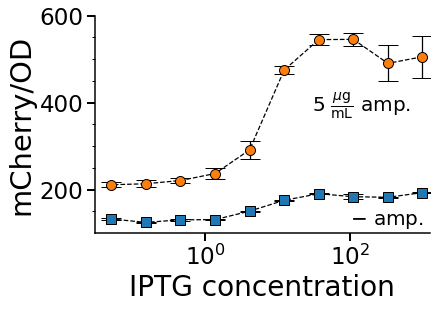

In [587]:
bdata1 = adata[adata.obs.condition.isin([1,2])].copy()
fln1 = {'mean':[],'std':[]} # last time point fln mean and std
this_time = 24 # hours
# convert time to index
this_ind = int(this_time*60/sampling_rate)
for iptg in bdata1.obs.concentration_1.unique().tolist():
    cdata = bdata1[bdata1.obs.concentration_1.isin([iptg])].copy()
    fln1_mtmp = list(np.mean(cdata.obsm['fln'], axis=0))[this_ind]
    fln1_stmp = list(np.std(cdata.obsm['fln'], axis=0))[this_ind]
#     fln1_mtmp = list(np.mean(cdata.obsm['fl'], axis=0))[this_ind]
#     fln1_stmp = list(np.std(cdata.obsm['fl'], axis=0))[this_ind]
    fln1['mean'].append(fln1_mtmp)
    fln1['std'].append(fln1_stmp)


bdata2 = adata[adata.obs.condition.isin([4,5])].copy()
fln2 = {'mean':[],'std':[]} # last time point fln mean and std
for iptg in bdata2.obs.concentration_1.unique().tolist():
    cdata = bdata2[bdata2.obs.concentration_1.isin([iptg])].copy()
    fln2_mtmp = list(np.mean(cdata.obsm['fln'], axis=0))[this_ind]
    fln2_stmp = list(np.std(cdata.obsm['fln'], axis=0))[this_ind]
#     fln2_mtmp = list(np.mean(cdata.obsm['fl'], axis=0))[this_ind]
#     fln2_stmp = list(np.std(cdata.obsm['fl'], axis=0))[this_ind]
    fln2['mean'].append(fln2_mtmp)
    fln2['std'].append(fln2_stmp)

plt.figure()
plt.errorbar(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],yerr=np.array(fln1['std'][0:]),
             fmt='s',ms=10,mec='k',mfc='tab:blue',ecolor='k',elinewidth=1.25,capsize=10)
plt.plot(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],'--',color='k',lw=1.25)
plt.errorbar(bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],yerr=np.array(fln2['std'][0:]),
             fmt='o',ms=10,mec='k',mfc='tab:orange',ecolor='k',elinewidth=1.25,capsize=10)
plt.plot(bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],'--',color='k',lw=1.25)
plt.xscale('log')
plt.xlim(.03,1250); plt.ylim(100,)
plt.text(100,120,r'$-$ amp.',fontsize=20)
plt.text(30,380,r'$5 \; \frac{\mu \mathrm{g}}{\mathrm{mL}}$ amp.',fontsize=20)
plt.xlabel('IPTG concentration',fontsize=28)
plt.ylabel('mCherry/OD',fontsize=29)
plt.show()


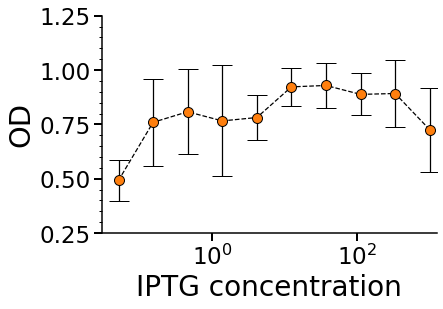

In [566]:
bdata1 = adata[adata.obs.condition.isin([1,2])].copy()
fln1 = {'mean':[],'std':[]} # last time point fln mean and std
this_time = 24 # hours
# convert time to index
this_ind = int(this_time*60/sampling_rate)
iptg_list = []
for iptg in bdata1.obs.concentration_1.unique().tolist():
    iptg_list.append(iptg)
    cdata = bdata1[bdata1.obs.concentration_1.isin([iptg])].copy()
    fln1_mtmp = list(np.mean(cdata.X, axis=0))[this_ind]
    fln1_stmp = list(np.std(cdata.X, axis=0))[this_ind]
    fln1['mean'].append(fln1_mtmp)
    fln1['std'].append(fln1_stmp)


bdata2 = adata[adata.obs.condition.isin([4,5])].copy()
fln2 = {'mean':[],'std':[]} # last time point fln mean and std
for iptg in bdata2.obs.concentration_1.unique().tolist():
    cdata = bdata2[bdata2.obs.concentration_1.isin([iptg])].copy()
    fln2_mtmp = list(np.mean(cdata.X, axis=0))[this_ind]
    fln2_stmp = list(np.std(cdata.X, axis=0))[this_ind]
    fln2['mean'].append(fln2_mtmp)
    fln2['std'].append(fln2_stmp)

plt.figure()
# plt.errorbar(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],yerr=np.array(fln1['std'][0:]),
#              fmt='s',ms=10,mec='k',mfc='tab:blue',ecolor='k',elinewidth=1.25,capsize=10)
# plt.plot(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],'--',color='k',lw=1.25)
plt.errorbar(iptg_list,bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],yerr=np.array(fln2['std'][0:]),
             fmt='o',ms=10,mec='k',mfc='tab:orange',ecolor='k',elinewidth=1.25,capsize=10)
plt.plot(iptg_list,bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],'--',color='k',lw=1.25)
plt.xscale('log')
plt.xlim(.03,1250);# plt.ylim(100,)
# plt.text(100,120,r'$-$ amp.',fontsize=20)
# plt.text(30,380,r'$5 \; \frac{\mu \mathrm{g}}{\mathrm{mL}}$ amp.',fontsize=20)
plt.xlabel('IPTG concentration',fontsize=28)
plt.ylabel('OD',fontsize=29)
plt.show()


The above figure warrants conducting 2D serial dilution experiment with IPTG varying along columns and ampicillin varying along rows. Maybe 6 IPTG concentrations and 3 ampicillin concentrations

### MG1655 Delta LacI with mepM overexpression plasmid - mepM titration and mCherry measurements (12.15.22) - 8 IPTG concentrations (colony 2) 

In [6]:
dataFile = 'mg1655DeltaLacI_mepMoverexpress_amp_12.15.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgDeltaLacI_mepMover_12.15.22'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


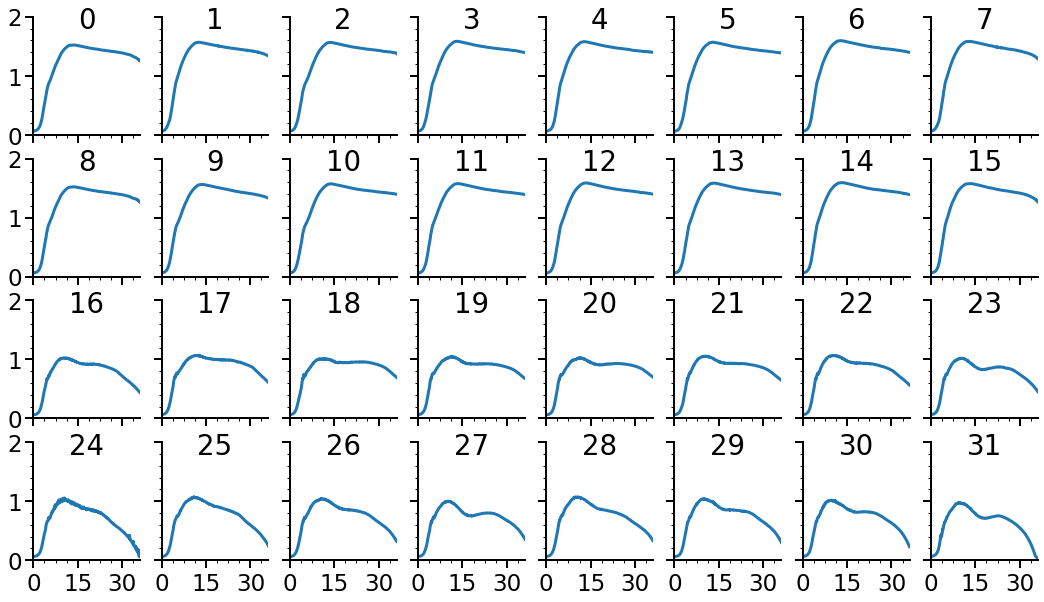

In [7]:
fig, axs = plt.subplots(4,8,figsize=(18,10),sharex=True,sharey=True)
axs = axs.reshape(-1)
plt.setp(axs, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii, ax in enumerate(axs): 
    ax.set_title(ii,y=0.85)
    ax.plot(adata.uns['t'], adata.X[ii])
#     ax.plot(adata.uns['t'], adata.obsm['fln'].iloc[ii])
#     ax.plot(adata.uns['t'], adata.obsm['fl'].iloc[ii])
# plt.tight_layout()
plt.show()

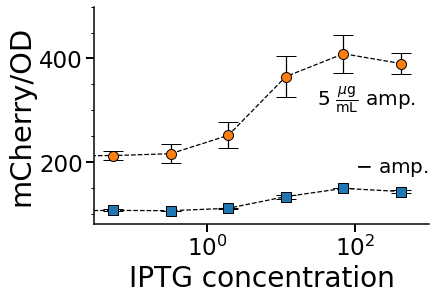

In [591]:
bdata1 = adata[adata.obs.condition.isin([0,1])].copy()
fln1 = {'mean':[],'std':[]} # last time point fln mean and std
this_time = 24 # hours
# convert time to index
this_ind = int(this_time*60/sampling_rate)
for iptg in bdata1.obs.concentration_1.unique().tolist():
    cdata = bdata1[bdata1.obs.concentration_1.isin([iptg])].copy()
    fln1_mtmp = list(np.mean(cdata.obsm['fln'], axis=0))[this_ind]
    fln1_stmp = list(np.std(cdata.obsm['fln'], axis=0))[this_ind]
    fln1['mean'].append(fln1_mtmp)
    fln1['std'].append(fln1_stmp)


bdata2 = adata[adata.obs.condition.isin([2,3])].copy()
fln2 = {'mean':[],'std':[]} # last time point fln mean and std
for iptg in bdata2.obs.concentration_1.unique().tolist():
    cdata = bdata2[bdata2.obs.concentration_1.isin([iptg])].copy()
    fln2_mtmp = list(np.mean(cdata.obsm['fln'], axis=0))[this_ind]
    fln2_stmp = list(np.std(cdata.obsm['fln'], axis=0))[this_ind]
    fln2['mean'].append(fln2_mtmp)
    fln2['std'].append(fln2_stmp)

plt.figure()
plt.errorbar(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],yerr=np.array(fln1['std'][0:]),
             fmt='s',ms=10,mec='k',mfc='tab:blue',ecolor='k',elinewidth=1.25,capsize=10)
plt.plot(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],'--',color='k',lw=1.25)
plt.errorbar(bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],yerr=np.array(fln2['std'][0:]),
             fmt='o',ms=10,mec='k',mfc='tab:orange',ecolor='k',elinewidth=1.25,capsize=10)
plt.plot(bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],'--',color='k',lw=1.25)
plt.xscale('log')
plt.xlim(.03,); plt.ylim(80,)
# plt.yscale('log')
plt.text(100,180,r'$-$ amp.',fontsize=20)
plt.text(30,310,r'$5 \; \frac{\mu \mathrm{g}}{\mathrm{mL}}$ amp.',fontsize=20)
plt.xlabel('IPTG concentration',fontsize=28)
plt.ylabel('mCherry/OD',fontsize=29)
plt.show()


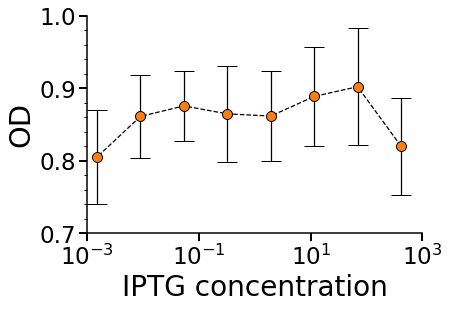

In [625]:
bdata1 = adata[adata.obs.condition.isin([0,1])].copy()
fln1 = {'mean':[],'std':[]} # last time point fln mean and std
this_time = 24 # hours
# convert time to index
this_ind = int(this_time*60/sampling_rate)
for iptg in bdata1.obs.concentration_1.unique().tolist():
    cdata = bdata1[bdata1.obs.concentration_1.isin([iptg])].copy()
    fln1_mtmp = list(np.mean(cdata.X, axis=0))[this_ind]
    fln1_stmp = list(np.std(cdata.X, axis=0))[this_ind]
    fln1['mean'].append(fln1_mtmp)
    fln1['std'].append(fln1_stmp)


bdata2 = adata[adata.obs.condition.isin([2,3])].copy()
fln2 = {'mean':[],'std':[]} # last time point fln mean and std
for iptg in bdata2.obs.concentration_1.unique().tolist():
    cdata = bdata2[bdata2.obs.concentration_1.isin([iptg])].copy()
    fln2_mtmp = list(np.mean(cdata.X, axis=0))[this_ind]
    fln2_stmp = list(np.std(cdata.X, axis=0))[this_ind]
    fln2['mean'].append(fln2_mtmp)
    fln2['std'].append(fln2_stmp)

plt.figure()
# plt.errorbar(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],yerr=np.array(fln1['std'][0:]),
#              fmt='s',ms=10,mec='k',mfc='tab:blue',ecolor='k',elinewidth=1.25,capsize=10)
# plt.plot(bdata1.obs.concentration_1.unique().tolist()[0:],fln1['mean'][0:],'--',color='k',lw=1.25)
plt.errorbar(bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],yerr=np.array(fln2['std'][0:]),
             fmt='o',ms=10,mec='k',mfc='tab:orange',ecolor='k',elinewidth=1.25,capsize=10)
plt.plot(bdata2.obs.concentration_1.unique().tolist()[0:],fln2['mean'][0:],'--',color='k',lw=1.25)
plt.xscale('log')
# plt.xlim(.03,1250);# plt.ylim(100,)
# plt.text(100,120,r'$-$ amp.',fontsize=20)
# plt.text(30,380,r'$5 \; \frac{\mu \mathrm{g}}{\mathrm{mL}}$ amp.',fontsize=20)
plt.xlabel('IPTG concentration',fontsize=28)
plt.ylabel('OD',fontsize=29)
plt.show()


### MG1655 Delta LacI with mepM overexpression plasmid - mepM titration and mCherry measurements (12.22.22) - 9 IPTG concentrations and 5 ampicillin concentrations (colony 3) 

In [22]:
dataFile = 'mg1655_mepMover_double_titrate_12.22.22.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgDeltaLacI_mepMover_12.22.22'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


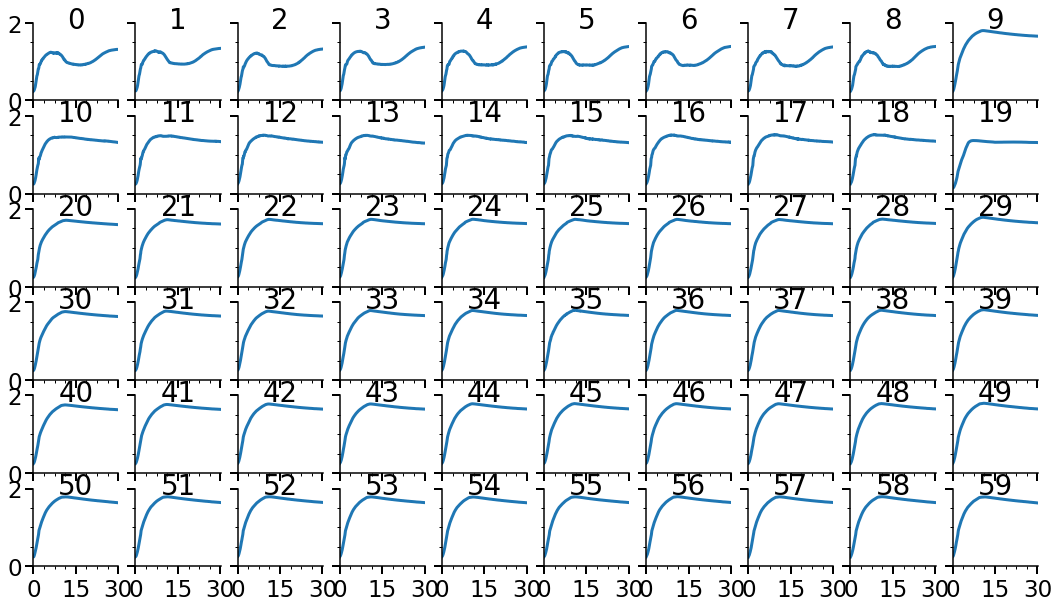

In [643]:
fig, axs = plt.subplots(6,10,figsize=(18,10),sharex=True,sharey=True)
axs = axs.reshape(-1)
plt.setp(axs, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii, ax in enumerate(axs): 
    ax.set_title(ii,y=0.85)
    ax.plot(adata.uns['t'], adata.X[ii])
#     ax.plot(adata.uns['t'], adata.obsm['fln'].iloc[ii])
#     ax.plot(adata.uns['t'], adata.obsm['fl'].iloc[ii])
# plt.tight_layout()
plt.show()

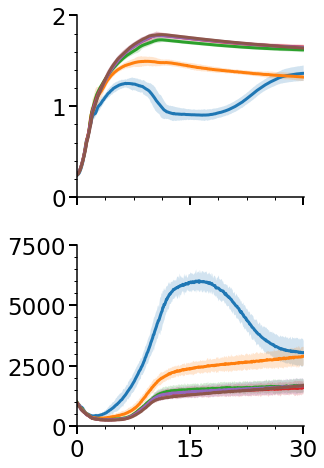

In [695]:
fig, ax = plt.subplots(2,1,figsize=(5,7),sharex=True)
plt.setp(ax, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii in range(6):
    cond  = np.sort(adata.obs.condition.unique())[ii] # condition indexes by amp concentration
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    od = np.mean(bdata.X,axis=0)
    od_std = np.std(bdata.X,axis=0)
    fln = np.mean(bdata.obsm['fln'],axis=0)
    fln_std = np.std(bdata.obsm['fln'],axis=0)
    ax[0].plot(adata.uns['t'],od)
    ax[0].fill_between(adata.uns['t'],od-3*od_std,od+3*od_std,alpha=0.2)
    ax[1].plot(adata.uns['t'],fln)
    ax[1].fill_between(adata.uns['t'],fln-3*fln_std,fln+3*fln_std,alpha=0.2)
# plt.xlim(0,5)
plt.tight_layout()
plt.show()

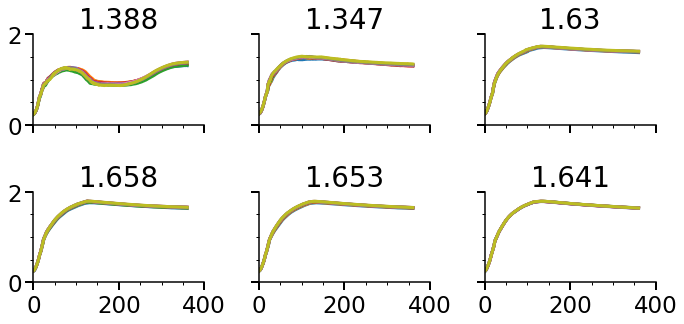

In [652]:
fig, axs = plt.subplots(2,3,figsize=(10,5),sharex=True,sharey=True)
axs = axs.reshape(-1)
for ii, ax in enumerate(axs):
    cond  = np.sort(adata.obs.condition.unique())[ii] # condition indexes by amp concentration
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    for iptg_conc in bdata.obs.concentration_1.unique(): 
        cdata = bdata[bdata.obs.concentration_1.isin([iptg_conc])].copy()
        ax.plot(cdata.X.T)
        ax.set_title(cdata.X.T[-1][0])
plt.tight_layout()
plt.show()

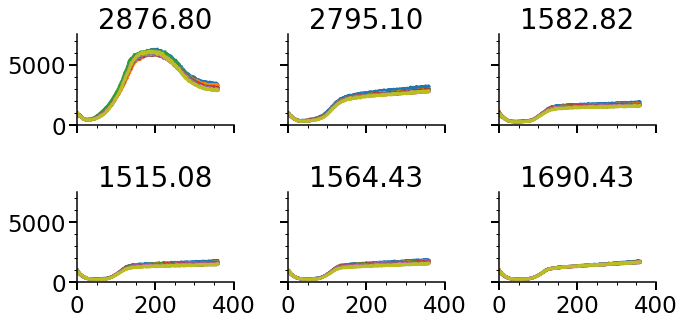

In [664]:
fig, axs = plt.subplots(2,3,figsize=(10,5),sharex=True,sharey=True)
axs = axs.reshape(-1)
for ii, ax in enumerate(axs):
    cond  = np.sort(adata.obs.condition.unique())[ii] # condition indexes by amp concentration
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    for iptg_conc in bdata.obs.concentration_1.unique(): 
        cdata = bdata[bdata.obs.concentration_1.isin([iptg_conc])].copy()
        ax.plot(cdata.obsm['fln'].T)
        ax.set_title(f'{cdata.obsm["fln"].T.iloc[-1][0]:.2f}')
plt.tight_layout()
plt.show()

### MGZ1 with pATdCasRx and pMepMover

In [11]:
dataFile = 'mgz1_mepMover_dCasRx_2.04.23.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_mepMover_amp_2.4.23'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

RangeIndex(start=0, stop=433, step=1)
Index(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'D2', 'D3',
       'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'E2', 'E3', 'E4',
       'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'F2', 'F3', 'F4', 'F5',
       'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'G10', 'G11'],
      dtype='object', name='well')


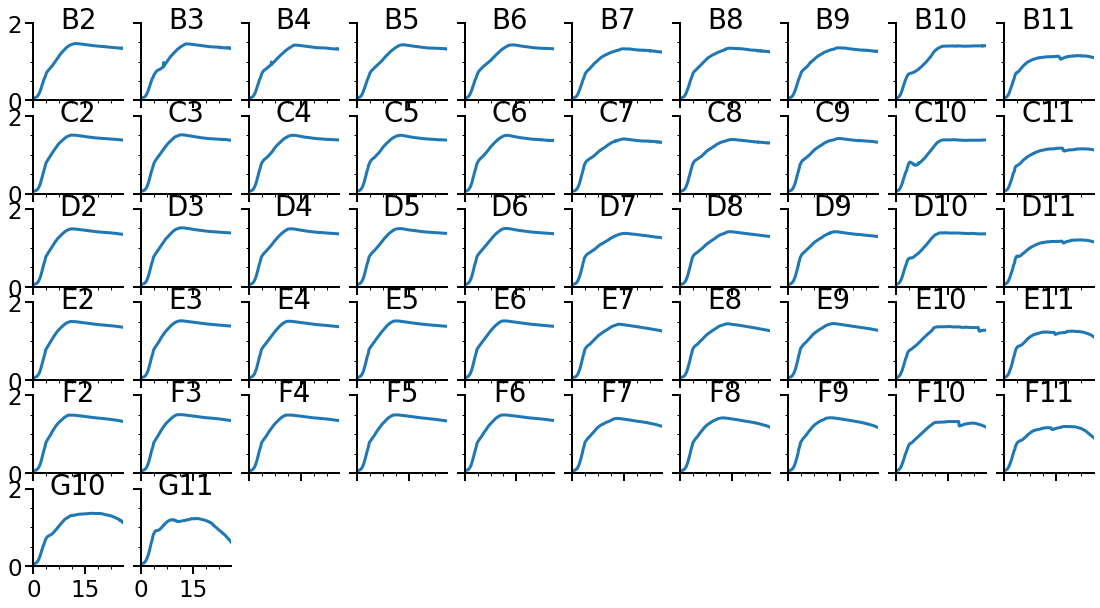

In [12]:
fig, axs = plt.subplots(6,10,figsize=(19,10),sharex=True,sharey=True)
for ii in range(1,9):
    fig.delaxes(axs[-1,-ii]);  
axs = axs.reshape(-1)
plt.setp(axs, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii, ax in enumerate(axs): 
    if ii < adata.X.shape[0]:
        ax.set_title(adata.obs.index[ii],y=0.85)
        ax.plot(adata.uns['t'], adata.X[ii])
    #     ax.plot(adata.uns['t'], adata.obsm['fln'].iloc[ii])
    #     ax.plot(adata.uns['t'], adata.obsm['fl'].iloc[ii])
# plt.tight_layout()
plt.xlim(0,26)
plt.show()

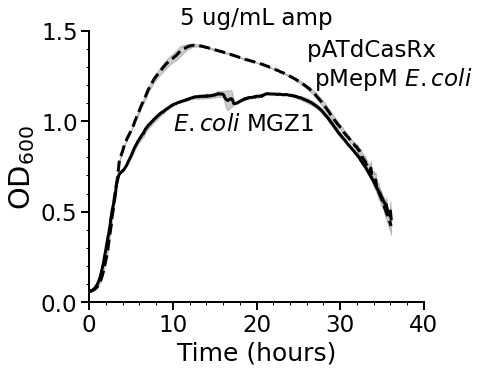

In [174]:
savefig = False

labels = ['$\it{E. coli}$ MGZ1', 'pATdCasRx \n pMepM $\it{E. coli}$']

plt.figure(figsize=(6,5))
plt.title('5 ug/mL amp',fontsize=23)
mean = adata[['F7','F8','F9']].X.toarray().mean(axis=0)
std = adata[['F7','F8','F9']].X.toarray().std(axis=0)
plt.plot(adata.uns['t'],mean,'--k') 
plt.fill_between(adata.uns['t'],mean-std,mean+std,color='k',alpha=0.2) 
mean = adata[['B11','C11']].X.toarray().mean(axis=0)
std = adata[['B11','C11']].X.toarray().std(axis=0)
plt.plot(adata.uns['t'],mean,'-k') 
plt.fill_between(adata.uns['t'],mean-std,mean+std,color='k',alpha=0.2) 
# plt.ylim(0,1.7)
# plt.xlim(0,30)
plt.text(26,1.2,labels[1])
plt.text(10,0.95,labels[0])
plt.xlabel('Time (hours)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
if savefig: 
    plt.savefig(figDir+'supplementalFigs/mgz1_gcs_amp5.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()


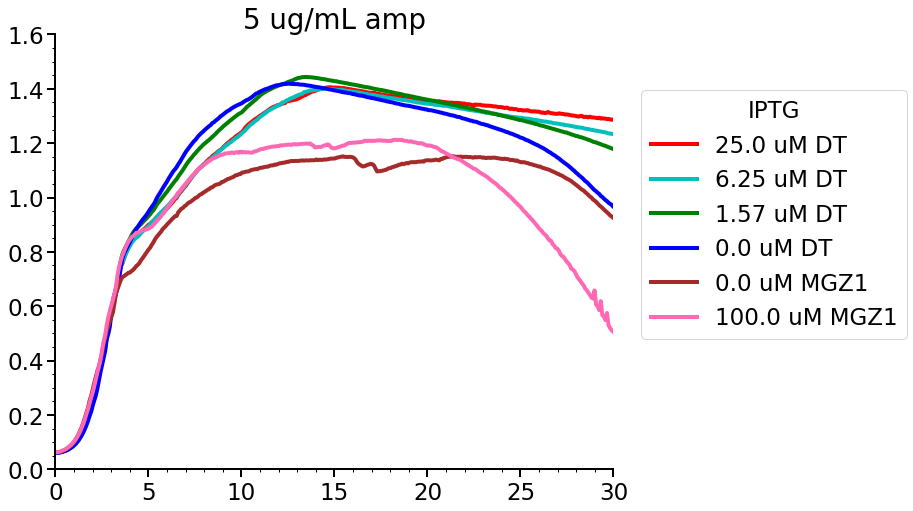

In [116]:
plt.figure(figsize=(10,8))
plt.title('5 ug/mL amp')
# plt.plot(adata.uns['t'],adata[['B2','B3']].X.toarray().mean(axis=0),color='r',lw=4) # shows toxicity to IPTG at this concentration
# plt.plot(adata.uns['t'],adata[['C2','C3']].X.toarray().mean(axis=0),color='c',lw=4) 
# plt.plot(adata.uns['t'],adata[['D2','D3']].X.toarray().mean(axis=0),color='purple',lw=4) 
# plt.plot(adata.uns['t'],adata[['E2','E3']].X.toarray().mean(axis=0),color='orange',lw=4) 
# plt.plot(adata.uns['t'],adata[['F2','F3']].X.toarray().mean(axis=0),color='b',lw=4) 
plt.plot(adata.uns['t'],adata[['C7','C8','C9']].X.toarray().mean(axis=0),color='r',lw=4,label='25.0 uM DT') 
plt.plot(adata.uns['t'],adata[['D7','D8','D9']].X.toarray().mean(axis=0),color='c',lw=4,label='6.25 uM DT') 
plt.plot(adata.uns['t'],adata[['E7','E8','E9']].X.toarray().mean(axis=0),color='g',lw=4,label='1.57 uM DT') 
plt.plot(adata.uns['t'],adata[['F7','F8','F9']].X.toarray().mean(axis=0),color='b',lw=4,label='0.0 uM DT') 
plt.plot(adata.uns['t'],adata[['B11','C11']].X.toarray().mean(axis=0),color='brown',lw=4,label='0.0 uM MGZ1') 
plt.plot(adata.uns['t'],adata[['E11','F11','G11']].X.toarray().mean(axis=0),color='hotpink',lw=4,label='100.0 uM MGZ1') 
plt.legend(frameon=True,loc=(1.05,0.3),title='IPTG')
# plt.ylim(0,1.7)
plt.xlim(0,30)
plt.show()

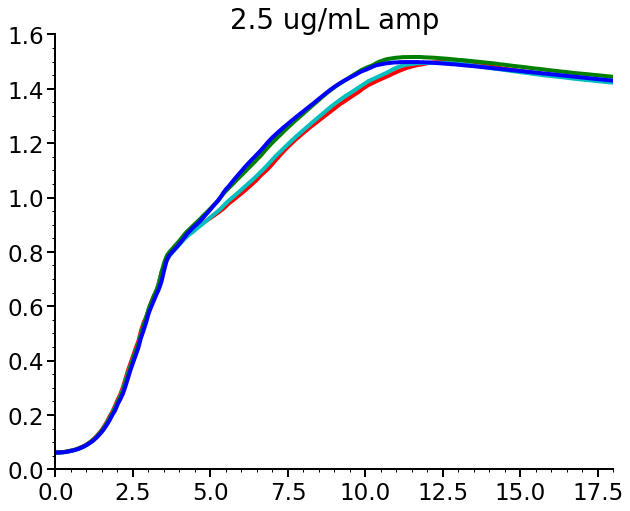

In [115]:
plt.figure(figsize=(10,8))
plt.title('2.5 ug/mL amp')
plt.plot(adata.uns['t'],adata[['C4','C5','C6']].X.toarray().mean(axis=0),color='r',lw=4) 
plt.plot(adata.uns['t'],adata[['D4','D5','D6']].X.toarray().mean(axis=0),color='c',lw=4) 
plt.plot(adata.uns['t'],adata[['E4','E5','E6']].X.toarray().mean(axis=0),color='g',lw=4) 
plt.plot(adata.uns['t'],adata[['F4','F5','F6']].X.toarray().mean(axis=0),color='b',lw=4) 
# plt.ylim(0,1.7)
plt.xlim(0,18)
plt.show()

### MGZ1 with pMepMover and preliminary biapenem and cefazolin

In [90]:
dataFile = 'mgz1_mepMoverexpress_amp_2.9.23.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_3antibiotics_2.9.23'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


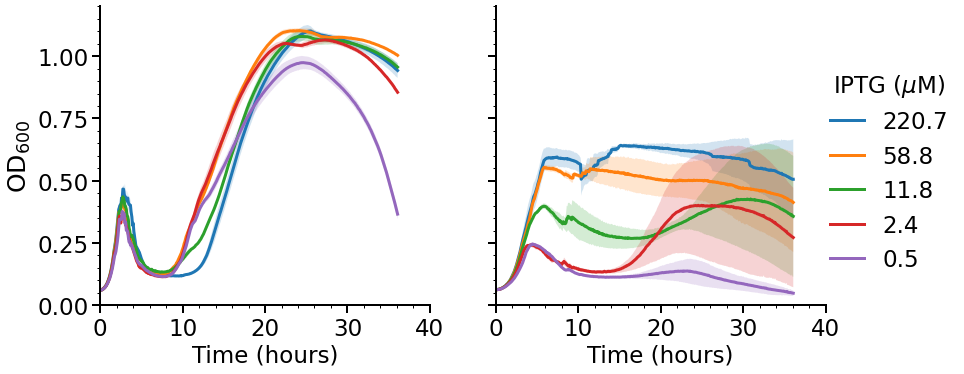

In [85]:
conditions = [[0,1,2,3,4],[5,6,7,8,9]]
fig, axs = plt.subplots(1,2,figsize=(13,5.5),sharex=True,sharey=True)
alpha = 0.2
for jj, ax in enumerate(axs.reshape(-1)):
    for ii, cond in enumerate(conditions[jj]): 
        bdata = adata[adata.obs.condition.isin([cond])].copy()
        iptg_conc = bdata.obs.concentration_1[0]
        iptg_unit = bdata.obs.concentration_unit_1[0]
        mean = np.mean(bdata.X,axis=0)
        std = np.std(bdata.X,axis=0)
        ax.plot(adata.uns['t'],mean,label=f'{iptg_conc:.1f}')
        ax.fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
# plt.ylim(0,)
axs[0].set_xlabel('Time (hours)',fontsize=23); axs[1].set_xlabel('Time (hours)',fontsize=23);
axs[0].set_ylabel(r'OD$_{600}$',fontsize=25);
plt.legend(frameon=False,fontsize=23,bbox_to_anchor=(0.95,0.85),ncol=1,title=r'IPTG ($\mu$M)',handlelength=1.5)

plt.show()

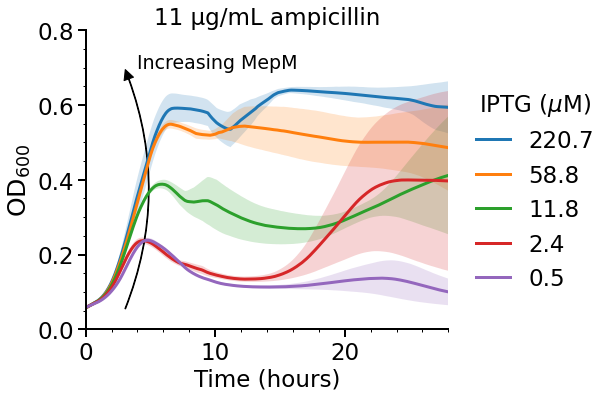

In [86]:
savefig = False

condition = [5,6,7,8,9]
plt.figure(figsize=(6.5,5.5))

style = "Simple, tail_width=0.75, head_width=10, head_length=10"
kw = dict(arrowstyle=style, color="k")
arrow = patches.FancyArrowPatch((3, 0.05), (3, 0.7),connectionstyle="arc3,rad=.2", **kw)

alpha = 0.2
plt.title(r'11 µg/mL ampicillin',fontsize=23)
for ii, cond in enumerate(condition): 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    iptg_conc = bdata.obs.concentration_1[0]
    iptg_unit = bdata.obs.concentration_unit_1[0]
    mean = savgol(np.mean(bdata.X,axis=0),21,1)
    std = savgol(np.std(bdata.X,axis=0),21,1)
    plt.plot(adata.uns['t'],mean,label=f'{iptg_conc:.1f}')
    plt.fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
plt.gca().add_patch(arrow)
plt.text(4,0.7, 'Increasing MepM',fontsize=19)
plt.xlim(0,28)
plt.xlabel('Time (hours)',fontsize=23)
plt.ylabel(r'OD$_{600}$',fontsize=25);
plt.legend(frameon=False,fontsize=23,loc=(1.05,0.1),ncol=1,title=r'IPTG ($\mu$M)',handlelength=1.5)
if savefig:
    plt.savefig(figDir+'fig5/mgz1_amp_gcs.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

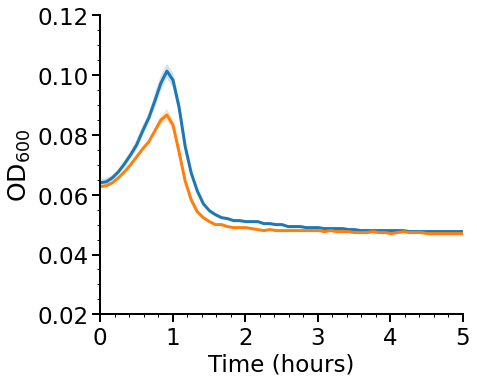

In [97]:
condition = [12,15]
plt.figure(figsize=(6.5,5.5))

alpha = 0.2
for ii, cond in enumerate(condition): 
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    plt.plot(adata.uns['t'],mean,label=f'{iptg_conc:.1f}')
    plt.fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
plt.xlim(0,5)
plt.xlabel('Time (hours)',fontsize=23)
plt.ylabel(r'OD$_{600}$',fontsize=25);
# plt.legend(frameon=False,fontsize=23,loc=(1.05,0.1),ncol=1,title=r'IPTG ($\mu$M)',handlelength=1.5)

plt.show()

### Cefazolin and Biapenem Screens

In [4]:
dataFile = 'mgz1_dcasrx_cef_bia_2.25.23.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'mgz1_cef_bia_2.25.23'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/var/folders/s9/jslg0t1x19s8p_kd2svbjp8h0000gn/T/ipykernel_55591/1631208092.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


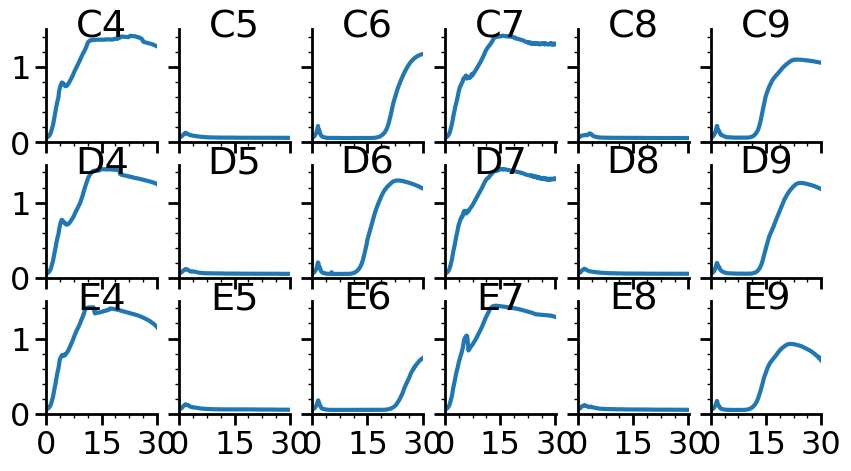

In [5]:
fig, axs = plt.subplots(3,6,figsize=(10,5),sharex=True,sharey=True) 
axs = axs.reshape(-1)
plt.setp(axs, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii, ax in enumerate(axs): 
    if ii < adata.X.shape[0]:
        ax.set_title(adata.obs.index[ii],y=0.85)
        ax.plot(adata.uns['t'], adata.X[ii])
    #     ax.plot(adata.uns['t'], adata.obsm['fln'].iloc[ii])
    #     ax.plot(adata.uns['t'], adata.obsm['fl'].iloc[ii])
# plt.tight_layout()
# plt.xlim(0,26)
plt.show()

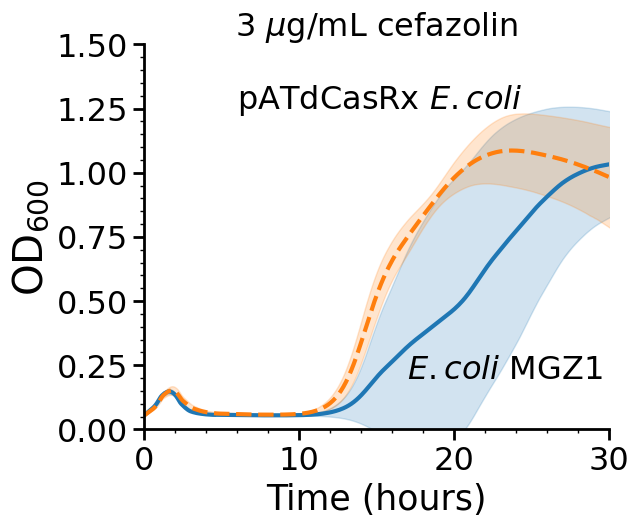

In [7]:
savefig = False

plt.figure(figsize=(6,5))
plt.title(r'3 $\mu$g/mL cefazolin',fontsize=23)
bdata = adata[adata.obs.condition.isin([3,5])].copy()
labels = ['$\it{E. coli}$ MGZ1', 'pATdCasRx $\it{E. coli}$']
linestyles = ['-','--']
colors=['tab:blue','tab:orange']
for ii, strain in enumerate(bdata.obs.strain.unique()):
    cdata = bdata[bdata.obs.strain.isin([strain])].copy()
    mean = savgol(np.mean(cdata.X,axis=0),15,1)
    std = savgol(np.std(cdata.X,axis=0),15,1)#/np.sqrt(3)
    plt.plot(adata.uns['t'],mean,linestyles[ii],c=colors[ii])
    plt.fill_between(adata.uns['t'],mean-std,mean+std,alpha=0.2,color=colors[ii])
plt.text(6,1.25,labels[1])
plt.text(17,0.2,labels[0])
plt.xlim(0,30)
plt.xlabel('Time (hours)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
plt.ylim(-0.0,1.5)
if savefig: 
    plt.savefig(figDir+'supplementalFigs/mgz1_gcs_cefazolin.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### NAND plasmid strain screens

In [28]:
dataFile = 'nand_plasmid_strains_amp_2.28.23.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'nand_plasmid_amp_2.28.23'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

/var/folders/s9/jslg0t1x19s8p_kd2svbjp8h0000gn/T/ipykernel_62208/1631208092.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


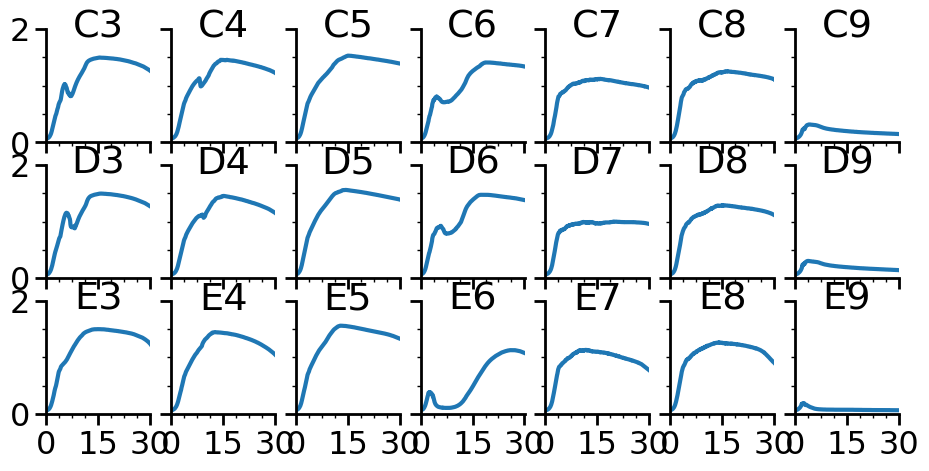

In [29]:
fig, axs = plt.subplots(3,7,figsize=(11,5),sharex=True,sharey=True) 
axs = axs.reshape(-1)
plt.setp(axs, xticks=range(0,45,15), xticklabels=range(0,45,15))
for ii, ax in enumerate(axs): 
    if ii < adata.X.shape[0]:
        ax.set_title(adata.obs.index[ii],y=0.85)
        ax.plot(adata.uns['t'], adata.X[ii])
    #     ax.plot(adata.uns['t'], adata.obsm['fln'].iloc[ii])
    #     ax.plot(adata.uns['t'], adata.obsm['fl'].iloc[ii])
# plt.tight_layout()
# plt.xlim(0,26)
plt.show()

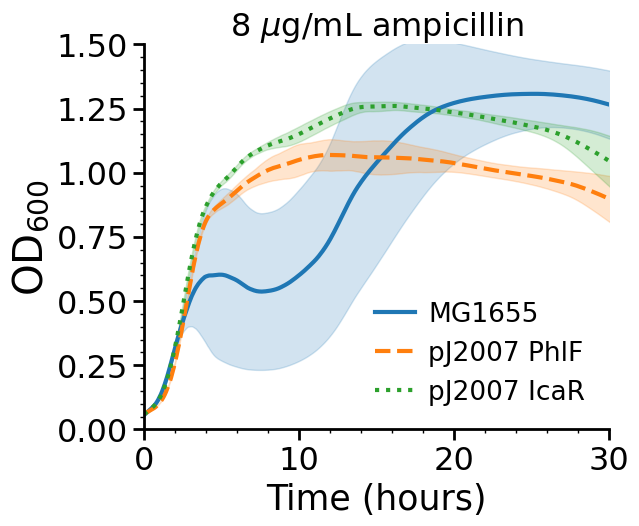

In [46]:
savefig = False

plt.figure(figsize=(6,5))
plt.title(r'8 $\mu$g/mL ampicillin',fontsize=23)
bdata = adata[adata.obs.condition.isin([3,4,5])].copy()
labels = ['MG1655', 'pJ2007 PhlF', 'pJ2007 IcaR']
linestyles = ['-','--',':']
colors=['tab:blue','tab:orange', 'tab:green']
for ii, strain in enumerate(bdata.obs.strain.unique()):
    cdata = bdata[bdata.obs.strain.isin([strain])].copy()
    mean = savgol(np.mean(cdata.X,axis=0),15,1)
    std = savgol(np.std(cdata.X,axis=0),15,1)
    plt.plot(adata.uns['t'],mean,linestyles[ii],c=colors[ii],label=labels[ii])
    plt.fill_between(adata.uns['t'],mean-std,mean+std,alpha=0.2,color=colors[ii])
# plt.text(6,1.25,labels[1])
# plt.text(17,0.2,labels[0])
plt.legend(frameon=False,fontsize=19,handletextpad=0.5,handlelength=1.5)
plt.xlim(0,30)
plt.xlabel('Time (hours)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
plt.ylim(-0.0,1.5)
if savefig: 
    plt.savefig(figDir+'supplementalFigs/nand_gcs_amp.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()